# Pôle Emploi Active Job Postings

Author: `pascal@bayes.org`
Date: 2016-09-05

Skip the run test because it would take too long to download the dataset.

This notebook provides a quick overview of the Active Job Postings dataset available on the Emploi Store Dev. It is updated every morning (at 6:00 in France) and contains only job postings that are still available on the Pôle Emploi website.

The original file is downloaded using the Python `emploi_store` module in the package `offres`, the resource named `Offres d'emploi`. You can use the make rule to download it:
```sh
docker-compose run --rm data-analysis-prepare make data/recent_job_offers.csv
```

In [1]:

import datetime
from os import path

import pandas as pd
import seaborn as _

from bob_emploi.data_analysis.lib import plot_helpers

DATA_PATH = '../../../data/'

pd.options.display.max_rows = 999

Let's import the file. Although after some tries it seems that some fields benefit from having a type set.

In [2]:
postings = pd.read_csv(
    path.join(DATA_PATH, 'recent_job_offers.csv'),
    dtype={'POSTCODE': str},
    parse_dates=['CREATION_DATE', 'MODIFICATION_DATE'], dayfirst=True, infer_datetime_format=True,
    low_memory=False)
postings.columns = postings.columns.str.lower()

# Fields
Let's check what are the fields available for each job posting.

In [3]:
postings.head(2).transpose()

,0,1
activity_code,7112B,7820Z
activity_name,"Ingénierie, études techniques",Activités des agences de travail temporaire
annual_maximum_salary,44000,18555.8
annual_minimum_salary,34000,18479.4
city_code,95127,44026
city_name,CERGY,CARQUEFOU
continent_code,NaN,NaN
continent_name,NaN,NaN
contract_duration,NaN,12
contract_dur_unit_code,NaN,MO


Unfortunately there is no fields that could help identify the company name or an email for the job seeker to contact. :-(

# Creation Date
Let's see how recent those job postings are.

100.00% of values in range


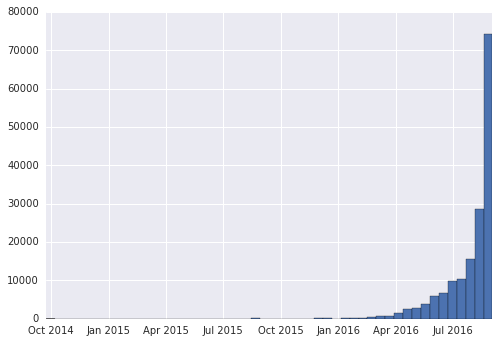

In [4]:
plot_helpers.hist_in_range(postings.creation_date, datetime.datetime(2014, 8, 1));

As expected most job postings don't last more than few months.

How many new ones do we get per day?

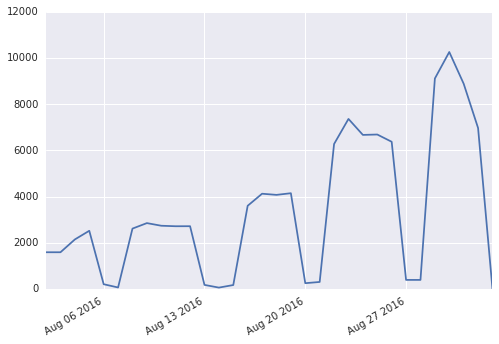

In [5]:
postings.creation_date[postings.creation_date > datetime.datetime(2016, 8, 1)].value_counts().plot();

So we get up to 10k job postings per day except during weekend days. Note that this result might be very very seasonal so let's take it as a very large approximation.

# I Want More!

In order for our app to suggest actual job offers we would need to get more info that is actually available in this dataset: name of the company, how to contact them, link a job posting from one day's data to another one. This would be easy if we could scrape the job posting that is on Pôle Emploi web pages and make it map this data (or actually only use a daily scrape from web). Note that another way would be to identify the fields we would like to have and ask them to Pôle Emploi (but then it wouldn't be anonymous job postings anymore).

We suggest a solution where we use the CSV to find out the newly created offers, and then a scraper to get the actual data.  The [advanced search page](https://candidat.pole-emploi.fr/candidat/rechercheoffres/avancee/A______P__________INDIFFERENT_______________________) allows to get 100 job postings with some filters, the results are returned with unique IDs.

# De-Anonymize

If we have data scraped from the web and the CSV downloaded from Emploi Store Dev, how easy would it be to match them? Here are some fields that are available in both datasets:
* creation date (not in search, only in display)
* rome profession code
* postcode for city-located jobs
* activity code (the two first items at least), which represents the sector or industry of the company

Let's see if that's enough to do unique matching.

In [6]:
postings['activity_group'] = postings['activity_code'].str[:2]
def _percent_of_uniques(fields, postings):
    dupes = postings[postings.duplicated(fields, keep=False)]
    return 100 - len(dupes) / len(postings) * 100
'{:.02f}%'.format(_percent_of_uniques(['creation_date', 'rome_profession_code', 'postcode', 'activity_group'], postings))

'86.42%'

So we can de-anonymize more than 85% of job postings. Let's see if we can do a bit better with additional fields.

In [7]:
'{:.02f}%'.format(_percent_of_uniques([
    'creation_date',
    'rome_profession_code',
    'postcode',
    'activity_group',
    'departement_code',
    'contract_type_code',
    'annual_minimum_salary',
    'annual_maximum_salary',
    'qualification_code',
    ],postings))

'92.03%'

With a lot more work we can de-anonymize 6% more, but I'm not sure it's worth it.

Let's try a de-anonymization manually:

In [8]:
_PE_SEARCH_PAGE = (
    'https://candidat.pole-emploi.fr/candidat/rechercheoffres/resultats/'
    'A__COMMUNE_{postcode}_5___{activity_group}-_____{rome_profession_code}____INDIFFERENT_______________________')
for s in postings.sample().itertuples():
    print(_PE_SEARCH_PAGE.format(s._asdict()))
    print(s.creation_date)

https://candidat.pole-emploi.fr/candidat/rechercheoffres/resultats/A__COMMUNE_76740_5___56-_____13861____INDIFFERENT_______________________
2016-08-16 00:00:00


Success! This search returns only one exact result and the date matches perfectly.

So we proved it could work for many many job offers, now having that in production is a bit harder as we would need to do daily:
* fetch the CSV from Pole Emploi Store Dev (~40 minutes)
* extract the ~10k new job postings (a simple filter)
* scrape the corresponding search pages to get the unique IDs (10k scrapes)
* (opt) scrape the actual job posting pages to get more info and not just a deep link (10k more scrapes)

Depending on how fast we can scrape Pôle Emploi this can take a long time.

# Conclusion

The dataset of job postings on Pole Emploi Store Dev is indeed anonymized however together with scraping the website we could get most of the info we're after. However given the long scraping time and the final result, it would be way easier if we could get Pôle Emploi to give us the unique ID (half the scraping time) and/or even better, the fields we're after (company name and contact).